# Histopathologic Cancer Detection

In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from PIL import Image

import os
from pathlib import Path
import shutil
from tqdm.auto import tqdm
from timeit import default_timer as timer
from typing import Dict, List

# Downloading Image Dataset

In a terminal, run the following command:

**Source:** https://www.kaggle.com/c/histopathologic-cancer-detection/data

```shell
kaggle competitions download -c histopathologic-cancer-detection
```

This downloads the `histopathologic-cancer-detection` dataset with `train` and `test` images in their respective directories. Each train image has an `image id` and a `label` specified in `train_labels.csv`.

File structure:

```txt
histopathologic-cancer-detection/
├── test/
│   └── img_1_test.tif
├── train/
│   └── img_1_train.tif
└── train_labels.csv

```

## Explore Dataset

In [2]:
DATA_DIR = Path.home() / 'Downloads' / 'histopathologic-cancer-detection'

TRAIN_DIR = DATA_DIR / 'train'
TEST_DIR = DATA_DIR / 'test'
LABELS_PATH = DATA_DIR / 'train_labels.csv'

In [3]:
def count_files(path, file_type: str) -> int:
    num_files = len(list(Path(path).glob(file_type)))
    return num_files

In [4]:
print(f'Number of Train Images: {count_files(TRAIN_DIR, "*.tif")}')
print(f'Number of Test Images: {count_files(TEST_DIR, "*.tif")}') 

Number of Train Images: 220025
Number of Test Images: 57458


### Examine Training Data

In [5]:
# get list of image file names
train_image_paths = list(Path(TRAIN_DIR).glob('*.tif'))

# observe the first 5 image names
print(f'Sample of Train Images:\n')
for i in train_image_paths[:5]:
    print(i.stem + i.suffix)

Sample of Train Images:

1d4434f36f4068a95df114b09b87299a026ea780.tif
17b17187e3858fa0aa5414d9712ce0dc959b7f9c.tif
dfd2afa456460108f9306c60831cd53da7edd304.tif
7426e502f6748c0299d8d80c1c28295014e07013.tif
b51d90692dc4572493745d92a496d59b88639cc7.tif


In [6]:
# observe train image labels
train_labels = pd.read_csv(DATA_DIR / 'train_labels.csv')

train_labels.head(5)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


### Training Class Balance

Label 0: 59.50 %
Label 1: 40.50 %


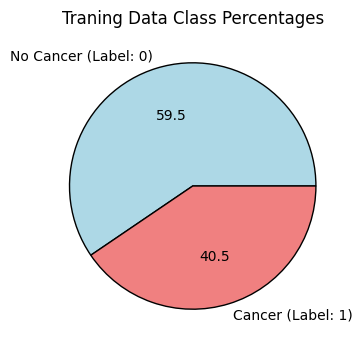

In [7]:
# examine training data's class balance
train_labels_counts = train_labels.label.value_counts()

print(f'Label 0: {train_labels_counts[0] / len(train_labels) * 100:.2f} %')
print(f'Label 1: {train_labels_counts[1] / len(train_labels) * 100:.2f} %')

plt.figure(figsize=(4, 4))
plt.pie(train_labels_counts,
        labels=['No Cancer (Label: 0)', 'Cancer (Label: 1)'],
        startangle=0, colors=['lightblue', 'lightcoral'],
        autopct='%1.1f',
        wedgeprops={'edgecolor': 'black',
                    'linewidth': 1})
plt.title('Traning Data Class Percentages')
plt.show()


### Observe Sample of Training Images

In [8]:
def view_sample_images(train_dir, file_type: str, train_labels_path, rows=2, n=16, cols=16//2, seed=4):
    # adjust random seed as you see fit
    np.random.seed(seed)

    train_image_paths = list(Path(train_dir).glob(f'*.{file_type}'))
    df_labels = pd.read_csv(train_labels_path)

    # get n random samples
    samples = np.random.choice(train_image_paths, n)
    print(len(samples))

    # display samples
    plt.figure(figsize=(14, 4))
    for i, img_path in enumerate(samples):
        with Image.open(img_path) as f:
            # get image label
            label = df_labels.loc[df_labels['id'] == img_path.stem, 'label'].values[0]

            plt.subplot(rows, cols, i+1)
            plt.imshow(f)
            plt.title(f'Label: {label}')
            plt.axis(False)

16


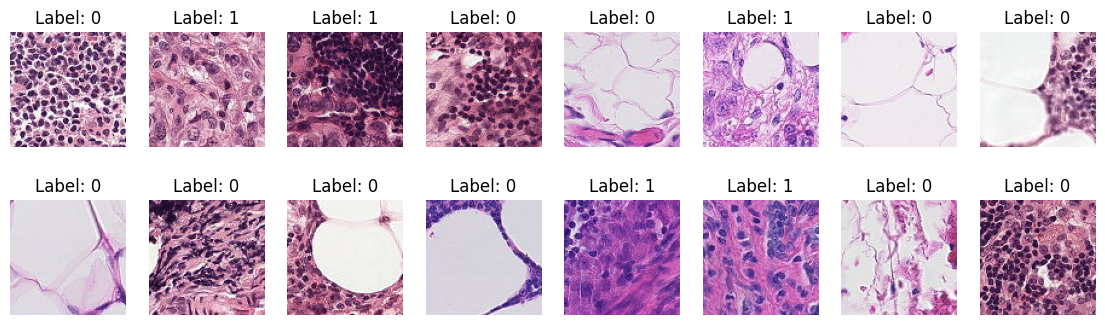

In [9]:
view_sample_images(TRAIN_DIR, 'tif', LABELS_PATH, seed=6)

# Data Preprocessing

The default dataset does not have available labels for images in `Test` directory. To have a test set with labels so that we can evaluate our model's performance on unseen data, we will partition a subset of the training data. Thus, the images in `Test` directory from the original download will not be used.

## Get Subset of Training Data

There are over 200,000 training images. The keep model training to a reasonable computational complexity due to hardware limitations, we'll get 10,000 samples.
- 6,000 samples of label 0
- 4,000 samples of label 1

In [10]:
def get_data_subset(train_dir, train_labels_path, file_type='*.tif', label_0=0.6, label_1=0.4, n_samples=10000, seed=4) -> list:
    """Gets a random subset of train image paths

    Returns:
        subset_paths (List)
    """
    # set random seed
    np.random.seed(seed)

    df_labels = pd.read_csv(train_labels_path)

    # get random samples of label 0
    n_samples_0 = int(label_0 * n_samples)
    df_0 = df_labels[df_labels.label == 0]
    samples_0 = df_0.sample(n=n_samples_0).reset_index(drop=True)

    # get random samples of label 1
    n_samples_1 = int(label_1 * n_samples)
    df_1 = df_labels[df_labels.label == 1]
    samples_1 = df_1.sample(n=n_samples_1).reset_index(drop=True)

    # get file paths of selected samples
    train_image_paths = list(Path(train_dir).glob(file_type))
    train_image_paths_stem = [i.stem for i in train_image_paths]

    # subset paths
    subset_paths = []
    total_iterations = len(samples_0) + len(samples_1)
    with tqdm(total=total_iterations) as pbar:
        for i in range(len(samples_0)):
            img_id = samples_0['id'][i]
            try:
                index = train_image_paths_stem.index(img_id)
                img_and_label = (train_image_paths[index], 0)
                subset_paths.append(img_and_label)
                pbar.update(1)
            except ValueError:
                print(f'img_id {img_id} not in train_image_paths_stem')
        
        for i in range(len(samples_1)):
            img_id = samples_1['id'][i]
            try:
                index = train_image_paths_stem.index(img_id)
                img_and_label = (train_image_paths[index], 1)
                subset_paths.append(img_and_label)
                pbar.update(1)
            except ValueError:
                print(f'img_id {img_id} not in train_image_paths_stem')
        
    return subset_paths

In [11]:
n_samples = 20000
seed = 9

subset_paths = get_data_subset(TRAIN_DIR, LABELS_PATH, n_samples=n_samples, seed=seed)

# sanity check
print(len(subset_paths))

  0%|          | 0/20000 [00:00<?, ?it/s]

20000


In [12]:
subset_paths[:5]

[(PosixPath('/home/akechi/Downloads/histopathologic-cancer-detection/train/7cde6569b20e1201822ebc06ba8c756e1df26939.tif'),
  0),
 (PosixPath('/home/akechi/Downloads/histopathologic-cancer-detection/train/71f77dacb21dc1d8846fcb902457446ba5d4ab80.tif'),
  0),
 (PosixPath('/home/akechi/Downloads/histopathologic-cancer-detection/train/31b86eacb2723c17ddcd831d8b2d68943df7d4d9.tif'),
  0),
 (PosixPath('/home/akechi/Downloads/histopathologic-cancer-detection/train/d960ec7ad1ba7eeca5995e421b88beffd7b806c1.tif'),
  0),
 (PosixPath('/home/akechi/Downloads/histopathologic-cancer-detection/train/ec1cfde6d36a49042ea0b26ae2cf83fa16af66ac.tif'),
  0)]

## Move Image Files Into Standard Structure For Training

We will apply `torchvision.datasets.ImageFolder` onto our structured directories, and then using `torch.utils.data.Dataloader` to make data management easier during model training.

**Standard Directory Structure For CNN Data:**

```txt
Downloads/
└── working/
    ├── train/
    │   ├── 0/
    │   │   └── img1.tif
    │   └── 1/
    │       └── img2.tif
    └── test/
        ├── 0/
        │   └── img3.tif
        └── 1/
            └── img4.tif
```

`subset_paths` is a list of tuples, with 1st item being image path, and 2nd item the image's label, as shown:
- `[(path/to/img1, label), (path/to/img2, label), ...]`

### Spit Data

In [13]:
def split_paths_and_labels(subset_paths: list, test_size=0.25, random_state=4):
    """
    Splits the subset training paths into training and test sets

    Parameters:
        subset_paths (list): list of image paths
    
    Returns:
        X_train (list), X_test (list), y_train (list), y_test (list)
    """
    # unpack
    X, y = zip(*subset_paths)

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True, random_state=random_state, stratify=y)

    return X_train, X_test, y_train, y_test

In [14]:
# split paths and labels
X_train, X_test, y_train, y_test = split_paths_and_labels(subset_paths, test_size=0.30)

In [15]:
# sanity check
print('Number of Samples:\n')

print(f'X: {len(X_train) + len(X_test)}')
print(f'y: {len(y_train) + len(y_test)}\n')

print(f'X_train: {len(X_train)}')
print(f'X_test: {len(X_test)}\n')
print(f'y_train: {len(y_train)}')
print(f'y_test: {len(y_test)}')

# observe
print(f'\nTrain sample: {X_train[0].stem, y_train[0]}')
print(f'Test sample: {X_test[0].stem, y_test[0]}')

Number of Samples:

X: 20000
y: 20000

X_train: 14000
X_test: 6000

y_train: 14000
y_test: 6000

Train sample: ('aec5ca4aa0a98d50f919613faf997217d75edb0b', 0)
Test sample: ('17528579b169be32adab645b3f31b150c10aa32d', 0)


### Copy Images to New Directory Structure

In [16]:
# function to remove any pre-existing data
def remove_old_data(path: Path):
    """
    Removes any pre-existing data in specified directory.

    Parameter:
        path (Path): path of target directory to clean
    """
    if path.is_dir():
        for item in path.iterdir():
            if item.is_file():
                # remove file
                item.unlink()
            elif item.is_dir():
                # recursively remove contents in subdirectories
                remove_old_data(item)

                # remove empty subdirectory
                item.rmdir()
    else:
        print(f'{path} is not a valid directory')


In [17]:
def make_working_directories(train_path, test_path, keep_old_data=False) -> None:
    """
    Creates standard directory structure for image classification using CNNs

    Parameters:
        train_path: path to training directory
        test_path: path to test directory
    
    """
    # declare paths
    train_0 = train_path / '0'
    train_1 = train_path / '1'
    
    test_0 = test_path / '0'
    test_1 = test_path / '1'

    print(f'Creating working directories...')
    # create directories
    Path(train_0).mkdir(parents=True, exist_ok=True)
    Path(train_1).mkdir(parents=True, exist_ok=True)

    Path(test_0).mkdir(parents=True, exist_ok=True)
    Path(test_1).mkdir(parents=True, exist_ok=True)

    print(f'Working directories created successfully!')

    if not keep_old_data:
        print(f'Removing old data...')

        remove_old_data(train_0)
        remove_old_data(train_1)
        remove_old_data(test_0)
        remove_old_data(test_1)

        print(f'Succesfully removed old data!\n')

In [18]:
def copy_files(train_path, test_path, X_train: list, y_train: list, X_test:list, y_test:list):

    # create working train & test directories
    make_working_directories(train_path=train_path, test_path=test_path)

    assert len(X_train) == len(y_train)
    assert len(X_test) == len(y_test)

    # copy over subset images to working directories
    # use tqdm to show progress
    print(f'Copying subset image samples...')
    
    total_iterations = len(X_train) + len(X_test)
    with tqdm(total=total_iterations) as pbar:
        for img, label in zip(X_train, y_train):
            if label == 0:
                shutil.copy(img, train_path / '0')
            if label == 1:
                shutil.copy(img, train_path / '1')
            pbar.update(1)
        
        for img, label in zip(X_test, y_test):
            if label == 0:
                shutil.copy(img, test_path / '0')
            if label == 1:
                shutil.copy(img, test_path / '1')
            pbar.update(1)
    
    print(f'Subset image samples copied successfully!')

In [19]:
# define target paths
WORKING_PATH = Path.home() / 'Downloads/working'

WORKING_TRAIN = WORKING_PATH / 'train'
WORKING_TEST = WORKING_PATH / 'test'

In [20]:
# copy subset image samples to working directories
copy_files(train_path=WORKING_TRAIN, test_path=WORKING_TEST, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

Creating working directories...
Working directories created successfully!
Removing old data...
Succesfully removed old data!

Copying subset image samples...


  0%|          | 0/20000 [00:00<?, ?it/s]

Subset image samples copied successfully!


In [21]:
print(f'X_train, label 0: {len(list(Path(WORKING_TRAIN / "0").iterdir()))}')
print(f'X_train, label 1: {len(list(Path(WORKING_TRAIN / "1").iterdir()))}\n')

print(f'X_test, label 0: {len(list(Path(WORKING_TEST / "0").iterdir()))}')
print(f'X_test, label 1: {len(list(Path(WORKING_TEST / "1").iterdir()))}')

X_train, label 0: 8400
X_train, label 1: 5600

X_test, label 0: 3600
X_test, label 1: 2400


## Create DataLoader

1. create function to transform images to `torch.tensor` type
2. load images using `ImageFolder`
3. turn image data into `DataLoader` for batch training

The following function resizes the images from `96x96` to `64x64` to reduce memory size used for training. `transforms.RandomHorizontalFlip` introduces some data augmentation to introduce more variability in training data so that model can better generalize. Lastly, convert images to tensors so it can be fed into model.

In [22]:
# applies various transformations to training images
data_transform_with_augment = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [23]:
# applies various transformations to training images
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [24]:
def load_image_data(working_train_path, working_test_path, transform=None):
    # load the image data
    train_data = datasets.ImageFolder(root=working_train_path,
                                    transform=transform,
                                    target_transform=None)

    test_data = datasets.ImageFolder(root=working_test_path,
                                    transform=transform,
                                    target_transform=None)

    return train_data, test_data

In [25]:
# load images into ImageFolder
train_data, test_data = load_image_data(working_train_path=WORKING_TRAIN, working_test_path=WORKING_TEST, transform=data_transform)

# observe
img, label = train_data[0][0], train_data[0][1]
print(f'ImageFolder Training Sample:\n')
print(f'Image tensor: {img}\n')
print(f'Image shape: {img.shape}')
print(f'Image dtype: {img.dtype}')
print(f'Label: {label}')
print(f'Label dtype: {type(label)}\n')

print(f'Class Labels Index: {train_data.class_to_idx}')

ImageFolder Training Sample:

Image tensor: tensor([[[0.8157, 0.8471, 0.8471,  ..., 0.7647, 0.9647, 0.9137],
         [0.8471, 0.7569, 0.7137,  ..., 0.8902, 0.9686, 0.7961],
         [0.9725, 0.9647, 0.9569,  ..., 0.9804, 0.8980, 0.8627],
         ...,
         [0.8392, 0.9137, 0.8784,  ..., 0.8471, 0.8745, 0.9529],
         [0.8549, 0.8353, 0.8353,  ..., 0.8392, 0.9020, 0.9216],
         [0.9451, 0.8902, 0.9020,  ..., 0.8431, 0.9020, 0.8549]],

        [[0.6157, 0.6392, 0.6235,  ..., 0.6902, 0.9333, 0.8824],
         [0.7412, 0.6471, 0.5843,  ..., 0.8196, 0.9098, 0.7059],
         [0.9647, 0.9412, 0.9216,  ..., 0.9412, 0.8039, 0.6980],
         ...,
         [0.5765, 0.6627, 0.6275,  ..., 0.5569, 0.5765, 0.6667],
         [0.6157, 0.5843, 0.5686,  ..., 0.5451, 0.6000, 0.6235],
         [0.7098, 0.6431, 0.6353,  ..., 0.5373, 0.5961, 0.5569]],

        [[0.7098, 0.7373, 0.7255,  ..., 0.7333, 0.9529, 0.9020],
         [0.8000, 0.7059, 0.6510,  ..., 0.8588, 0.9490, 0.7569],
         [0.98

In [26]:
def create_dataloader(train_data, test_data, batch_size=1, num_workers=1):
    train_dataloader = DataLoader(dataset=train_data,
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  shuffle=True)
    test_dataloader = DataLoader(dataset=test_data,
                                 batch_size=batch_size,
                                 num_workers=num_workers,
                                 shuffle=True)
    
    return train_dataloader, test_dataloader

In [27]:
# create dataloaders
BATCH_SIZE = 32
num_workers = 4

train_dataloader, test_dataloader = create_dataloader(train_data=train_data, test_data=test_data, batch_size=BATCH_SIZE, num_workers=num_workers)

# observe
print(f'training batches: {len(train_dataloader)}')
print(f'testing batchs: {len(test_dataloader)}')

training batches: 438
testing batchs: 188


# Modeling

## Simple Model

In [28]:
class SimpleModel(nn.Module):
    """
    Use a simple model with 3 convolutional layers
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int, input_length=64, input_width=64):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0
                      ),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0
                      ),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        # dynamically calculate flatten layer's output size by doing mock forward pass
        with torch.inference_mode():
            dummy_input = torch.randn(1, input_shape, input_length, input_width)
            dummy_output = self.conv_block_1(dummy_input)
            dummy_output = self.conv_block_2(dummy_output)
            flattened_output = torch.flatten(dummy_output, start_dim=1)
            
            # get the flattened output shape
            flattened_output_shape = flattened_output.shape[1]

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=flattened_output_shape,
                      out_features=output_shape)
        )
    
    def forward(self, x):
        x = self.conv_block_1(x)
        #print(x.shape)
        x = self.conv_block_2(x)
        #print(x.shape)
        x = self.classifier(x)
        #print(x.shape)
        return x

### Demo Forward Pass

In [29]:
# set random seed
torch.manual_seed(4)
torch.cuda.manual_seed(4)

# initiate simple model
simple_model = SimpleModel(input_shape=3,
                         hidden_units=10,
                         output_shape=1)
simple_model

SimpleModel(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=1, bias=True)
  )
)

In [30]:
# get a sample training batch
img_batch, label_batch = next(iter(train_dataloader))
print(f'img batch shape: {img_batch.shape}')
print(f'label batch shape: {label_batch.shape}\n')

with torch.inference_mode():
    y_pred_sample = simple_model(img_batch)
print(f'y_pred sample: {y_pred_sample[:5]}')

img batch shape: torch.Size([32, 3, 64, 64])
label batch shape: torch.Size([32])

y_pred sample: tensor([[-0.0593],
        [-0.0558],
        [-0.0547],
        [-0.0613],
        [-0.0540]])


### Create Training Loop

In [31]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device='cpu',
               threshold=0.5):
    """
    Performs the training loop for specified model.

    Parameters:
        model: PyTorch model
        dataloader: PyTorch dataloader
        loss_fn: loss function
        optimizer: optimizer
        device: either cpu or CUDA-based gpu
    """
    # put model in training mode
    model.train()

    # define loss function and accuracy metric
    train_loss, train_acc = 0, 0

    # loop through dataloader
    for batch, (X, y) in enumerate(dataloader):
        # send data to target device
        y = y.type(torch.float32)
        X, y = X.to(device), y.to(device)

        # forward pass
        # use sigmoid to convert logits to prediction probs
        # the probabilities and labels are for class 0
        y_pred = model(X) # output is logits
        y_pred_probs = torch.sigmoid(y_pred)
        y_pred_labels = (y_pred_probs >= threshold).int().squeeze()

        # calculate loss
        loss = loss_fn(y_pred.squeeze(), y)
        train_loss += loss.item()

        # zero grad
        optimizer.zero_grad()

        # backprop
        loss.backward()

        # update weights
        optimizer.step()

        # calculate accuracy metric
        acc = (y_pred_labels == y).sum().item() / len(y_pred_labels)
        train_acc += acc
    
    # get average loss & accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
        
    return train_loss, train_acc

### Create Testing Loop

In [32]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device='cpu',
              threshold=0.5):
    """
    Performs the testing loop for specified model.

    Parameters:
        model: PyTorch model
        dataloader: PyTorch dataloader
        loss_fn: loss function
        device: either cpu or CUDA-based gpu
    """
    # put model in test mode
    model.eval()

    # define loss and accuracy metric
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():    # disable gradient calculations to save memory and speed up computations
        # loop through dataloader
        for batch, (X, y) in enumerate(dataloader):
            # send data to target device
            y = y.type(torch.float32)
            X, y = X.to(device), y.to(device)

            # forward pass
            y_pred = model(X)
            y_pred_probs = torch.sigmoid(y_pred)
            y_pred_labels = (y_pred_probs >= threshold).int().squeeze()

            # calculate loss
            loss = loss_fn(y_pred.squeeze(), y)
            test_loss += loss.item()

            # calculate accuracy metric
            acc = (y_pred_labels == y).sum().item() / len(y_pred_labels)
            test_acc += acc
    
    # get average loss & accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc

### Complete Training & Evaluating Loop

In [33]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int=5,
          device='cpu'):
    """
    Performs the complete training and testing steps with specified model

    Parameters:
        model: PyTorch model,
        train_dataloader: PyTorch dataloader with training data
        test_dataloader: PyTorch dataloader with testing data
        loss_fn: loss function
        optimizer: optimizer
        epochs: number of times to iterate through entire training data
        device: either cpu or CUDA-based gpu
    """
    # create dictionary to hold train/test loss & accuracy
    results = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}
    
    # train and evaluate model for number of epochs
    for epoch in tqdm(range(1, epochs+1)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn, 
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)
        
        # print results
        print(f'EPOCH: {epoch}/{epochs} | Train Loss: {train_loss:.2f} | Train Acc: {train_acc:.2f} | Test Loss: {test_loss:.2f} | Test Acc: {test_acc:.2f}')

        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)
    
    return results

### Train & Evaluate Baseline Model

In [34]:
# get available device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [35]:
torch.cuda.reset_max_memory_allocated()

print(f'Current memory allocated: {torch.cuda.memory_allocated(device) / (1024**3):.2f} GB')
print(f'MAX memory allocated: {torch.cuda.memory_allocated(device) / (1024**3):.2f} GB')

Current memory allocated: 0.00
MAX memory allocated: 0.00


/home/akechi/anaconda3/envs/conan/lib/python3.11/site-packages/torch/cuda/memory.py:343: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [36]:
# random seed
torch.manual_seed(4)
torch.cuda.manual_seed(4)

EPOCHS = 30

# re-initiate model
simple_model = SimpleModel(input_shape=3,
                           hidden_units=10,
                           output_shape=1).to(device)

# loss & optimizer
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=simple_model.parameters(), lr=0.001)

print(f'Traning on Device: {device}')

# track training time
start = timer()

# train
simple_model_results = train(model=simple_model,
                             train_dataloader=train_dataloader,
                             test_dataloader=test_dataloader,
                             loss_fn=loss_fn,
                             optimizer=optimizer,
                             epochs=EPOCHS,
                             device=device)
end = timer()

print(f'\nTotal training time: {end - start:.2f} seconds')

Traning on Device: cuda


  0%|          | 0/30 [00:00<?, ?it/s]

EPOCH: 1/30 | Train Loss: 0.58 | Train Acc: 0.69 | Test Loss: 0.55 | Test Acc: 0.73
EPOCH: 2/30 | Train Loss: 0.49 | Train Acc: 0.78 | Test Loss: 0.49 | Test Acc: 0.77
EPOCH: 3/30 | Train Loss: 0.48 | Train Acc: 0.78 | Test Loss: 0.49 | Test Acc: 0.77
EPOCH: 4/30 | Train Loss: 0.47 | Train Acc: 0.79 | Test Loss: 0.46 | Test Acc: 0.79
EPOCH: 5/30 | Train Loss: 0.46 | Train Acc: 0.79 | Test Loss: 0.45 | Test Acc: 0.79
EPOCH: 6/30 | Train Loss: 0.44 | Train Acc: 0.80 | Test Loss: 0.44 | Test Acc: 0.80
EPOCH: 7/30 | Train Loss: 0.43 | Train Acc: 0.81 | Test Loss: 0.47 | Test Acc: 0.79
EPOCH: 8/30 | Train Loss: 0.42 | Train Acc: 0.82 | Test Loss: 0.43 | Test Acc: 0.80
EPOCH: 9/30 | Train Loss: 0.41 | Train Acc: 0.82 | Test Loss: 0.41 | Test Acc: 0.82
EPOCH: 10/30 | Train Loss: 0.40 | Train Acc: 0.82 | Test Loss: 0.39 | Test Acc: 0.83
EPOCH: 11/30 | Train Loss: 0.40 | Train Acc: 0.83 | Test Loss: 0.39 | Test Acc: 0.83
EPOCH: 12/30 | Train Loss: 0.39 | Train Acc: 0.83 | Test Loss: 0.39 | Test

In [37]:
print(f'Current memory allocated: {torch.cuda.memory_allocated(device) / (1024**3):.2f} GB')
print(f'MAX memory allocated: {torch.cuda.memory_allocated(device) / (1024**3):.2f} GB')

Current memory allocated: 0.02
MAX memory allocated: 0.02


### Plot Results

In [38]:
def plot_loss_curves(model_results: Dict[str, List[float]]):
    """
    Plots the train and test loss and accuracy curves.

    Parameters:
        model_results (dict): dictionary of model train loss, train accuracy, test loss, test accuracy
    """
    train_loss = model_results['train_loss']
    train_acc = model_results['train_acc']
    test_loss = model_results['test_loss']
    test_acc = model_results['test_acc']

    # sanity check
    assert len(train_loss) == len(train_acc) == len(test_loss) == len(test_acc)
    epochs = np.arange(1, len(train_loss)+1)

    plt.figure(figsize=(16, 4))

    # plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='train_loss', marker='o', markersize=4, color='dodgerblue')
    plt.plot(epochs, test_loss, label='test_loss', marker='o', markersize=4, color='deeppink')
    plt.title('Train & Test Loss')
    plt.xticks(ticks=epochs)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='train_acc', marker='o', markersize=4, color='dodgerblue')
    plt.plot(epochs, test_acc, label='test_acc', marker='o', markersize=4, color='deeppink')
    plt.title('Train & Test Accuracy')
    plt.xticks(ticks=epochs)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()


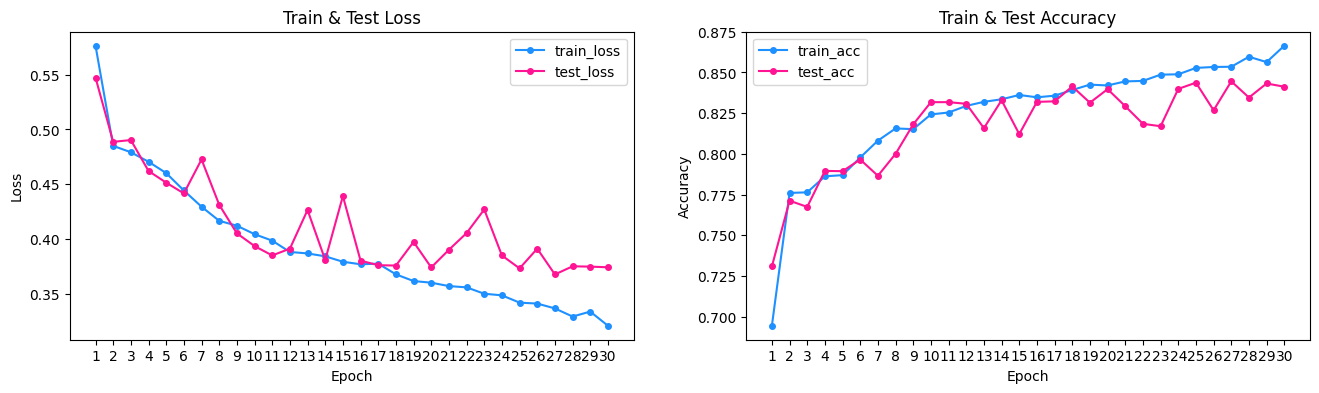

In [39]:
plot_loss_curves(simple_model_results)

Above we see that the baseline model performs relatively well from the start, better than a 50% accuracy by randomly guessing a sample's class. Training went for 30 epochs to observe the critical point of model overfitting. From the loss and accuracy plots, the training and testing loss diverge significantly around epoch 16. Thus future training can be early stopped here.

Another notable aspect of the plots are the spikes in decrease performance on the test set particularly in epoch 7, 12, 15. This could be due to encountering local minima in the loss function at these points when training on the training set. The model then adjusts in the next epoch, and we see test loss decrease close to the training loss as expected.

Furthermore, during data processing, transformations to the data include resizing to `64x64` and converting images to tensors for training. A seperate data transforming method includes augmentation such as horizontal flipping. Training was performed with and without this augmentation. The results displayed above are **without** augmentation for simplicity.

The loss and accuracy curves had a distictive feature such that train loss was always higher than test loss. Despite this, they both trended towards lower loss values over each epoch as the model better learned. Usually, we would expect the test loss to be higher than training loss because the model hasn't generalized to out of sample data in the early stages yet. However, I believe that the data augmentation transformation of horizontal flipping is one of the main reasons for observing a higher train loss throughout. That is because data augmentation introduces additional complexity that the model must learn, and makes it harder to generalize to such features. However, the test set is not augmented, and is simpler to predict on.

## Transfer Learning: Utilize Pre-Trained Model

Transfer learning allows to use pre-defined architectures and pre-trained models to speed up the training process. We'll implement the popular `resnet50` model

### Resize Input Images To Fit Model

We are using `resnet50` which requires input images of shape: `[3, 224, 224]`

In [40]:
# applies various transformations to training images to fit resnet50
data_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [41]:
# load and transform image data
train_data, test_data = load_image_data(WORKING_TRAIN, WORKING_TEST, transform=data_transform)

# create dataloaders
BATCH_SIZE = 32
num_workers = 4

train_dataloader, test_dataloader = create_dataloader(train_data=train_data, test_data=test_data, batch_size=BATCH_SIZE)


### Load Pre-Trained Model

In [42]:
class PreTrainedResNet50(nn.Module):
    """
    Uses the pretrained resnet50 model architecture
    """
    def __init__(self, num_classes=2):
        super().__init__()

        # load pretrained model
        self.resnet50 = resnet50(weights=ResNet50_Weights.DEFAULT)

        # freeze pretrained layers
        for param in self.resnet50.parameters():
            param.requires_grad = False
        
        # replace fully connected layer
        # if binary classifer, then we only need 1 output neuron
        if num_classes == 1 or num_classes == 2:
            num_classes = 1
        else:
            pass
        num_in_features = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Linear(num_in_features, num_classes)
    
    def forward(self, x):
        return self.resnet50(x)

### Train & Evaluate Pre-Trained Model

In [43]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [44]:
torch.cuda.reset_max_memory_allocated()

print(f'Current memory allocated: {torch.cuda.memory_allocated(device) / (1024**3):.2f} GB')
print(f'MAX memory allocated: {torch.cuda.memory_allocated(device) / (1024**3):.2f} GB')

Current memory allocated: 0.02
MAX memory allocated: 0.02


In [45]:
# random seed
torch.manual_seed(4)
torch.cuda.manual_seed(4)

# initiate model
pretrained_model = PreTrainedResNet50().to(device)

In [46]:
# loss & optimizer
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=pretrained_model.parameters(), lr=0.001)

EPOCHS = 10

print(f'Traning on Device: {device}')

# track training time
start = timer()

# train
pretrained_model_results = train(model=pretrained_model,
                                 train_dataloader=train_dataloader,
                                 test_dataloader=test_dataloader,
                                 loss_fn=loss_fn,
                                 optimizer=optimizer,
                                 epochs=EPOCHS,
                                 device=device)
end = timer()

print(f'\nTotal training time: {end - start:.2f} seconds')

Traning on Device: cuda


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH: 1/10 | Train Loss: 0.44 | Train Acc: 0.81 | Test Loss: 0.38 | Test Acc: 0.84
EPOCH: 2/10 | Train Loss: 0.36 | Train Acc: 0.85 | Test Loss: 0.35 | Test Acc: 0.86
EPOCH: 3/10 | Train Loss: 0.35 | Train Acc: 0.85 | Test Loss: 0.33 | Test Acc: 0.86
EPOCH: 4/10 | Train Loss: 0.34 | Train Acc: 0.86 | Test Loss: 0.33 | Test Acc: 0.87
EPOCH: 5/10 | Train Loss: 0.32 | Train Acc: 0.87 | Test Loss: 0.32 | Test Acc: 0.86
EPOCH: 6/10 | Train Loss: 0.31 | Train Acc: 0.87 | Test Loss: 0.31 | Test Acc: 0.87
EPOCH: 7/10 | Train Loss: 0.31 | Train Acc: 0.87 | Test Loss: 0.32 | Test Acc: 0.87
EPOCH: 8/10 | Train Loss: 0.30 | Train Acc: 0.87 | Test Loss: 0.31 | Test Acc: 0.87
EPOCH: 9/10 | Train Loss: 0.30 | Train Acc: 0.87 | Test Loss: 0.30 | Test Acc: 0.88
EPOCH: 10/10 | Train Loss: 0.30 | Train Acc: 0.87 | Test Loss: 0.31 | Test Acc: 0.87

Total training time: 949.22 seconds


In [49]:
print(f'Current memory allocated: {torch.cuda.memory_allocated(device) / (1024**3):.2f} GB')
print(f'MAX memory allocated: {torch.cuda.memory_allocated(device) / (1024**3):.2f} GB')

Current memory allocated: 0.10 GB
MAX memory allocated: 0.10 GB


### Plot Results

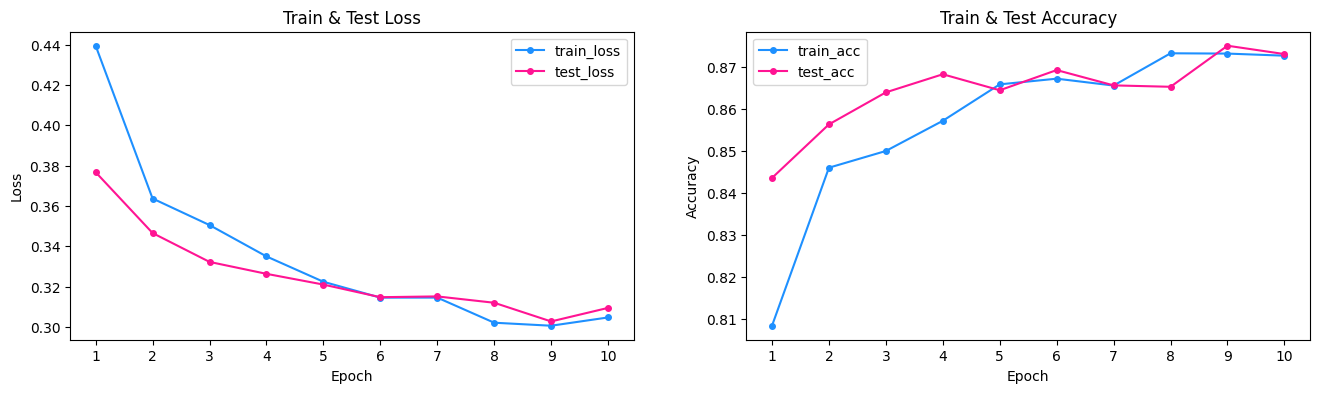

In [50]:
plot_loss_curves(pretrained_model_results)

# Save Model Parameters

In [54]:
WORKING_PATH / 'hello.pth'

PosixPath('/home/akechi/Downloads/working/hello.pth')

In [56]:
# save simple model
torch.save(simple_model.state_dict(), WORKING_PATH / 'simple_model.pth')

# save re-trained resnet50 model
torch.save(pretrained_model.state_dict(), WORKING_PATH / 'pretrained_resnet50.pth')

# Demo Loading Trained Model

Let's demo loading the re-trained resnet50 model

In [58]:
# create new model instance
loaded_resnet = PreTrainedResNet50()

# get trained model's state dict
trained_resnet_state_dict = torch.load(WORKING_PATH / 'pretrained_resnet50.pth', weights_only=True)

# load state dict into model
loaded_resnet.load_state_dict(trained_resnet_state_dict)

<All keys matched successfully>

In [63]:
loaded_resnet

PreTrainedResNet50(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential